In [3]:
from agent_load_testing.use_case_generator import generate_garage_use_case
from rlway_cpagent.osrd_adapter import regulation_problem_from_schedule, schedule_from_solution
from rlway_cpagent.ortools_agent.ortools_solver import OrtoolsRegulationSolver
from rlway_cpagent.minizinc_agent.minizinc_solver import MinizincRegulationSolver
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from agent_load_testing.load_testing import matrix_load_testing, linear_load_testing, load_testing

import nest_asyncio  
nest_asyncio.apply()

## Large problem generation

In [10]:
problem = generate_garage_use_case(50, 30, 0.05)

## Solve

In [12]:
solver = OrtoolsRegulationSolver("ortools", 86400, True)
solution = solver.solve(problem)
regulated_schedule = schedule_from_solution(solution)

print(solution.status)
df = pd.DataFrame(solver.history, columns=['computation_time', 'objective', 'born_inf'])
df.to_csv("./large_problem.csv", index=False)

OptimisationStatus.SUBOPTIMAL


## Viz Solution

In [4]:
df = pd.read_csv("./large_problem.csv")

<Axes: xlabel='Time'>

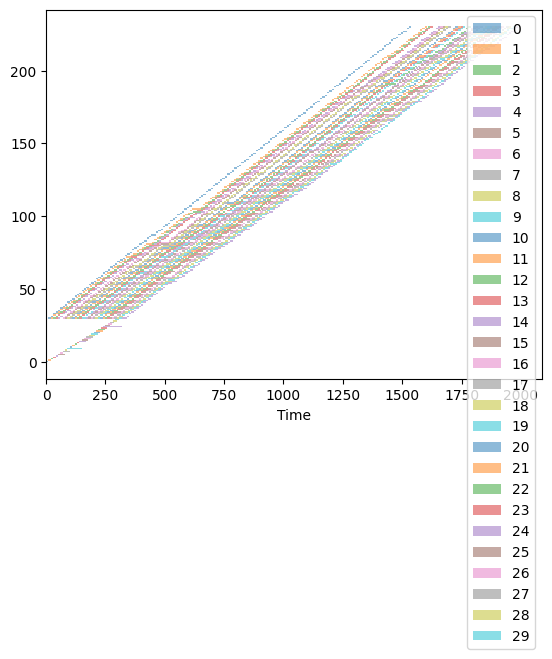

In [11]:
regulated_schedule.plot()

In [ ]:
times, delays, borns = zip(*solver.history)

In [5]:
data = df.to_numpy()
times, delays, borns = data.T

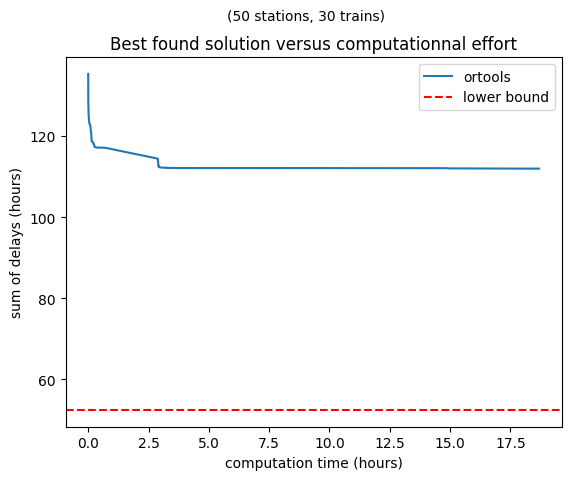

In [28]:

plt.plot(times/3600, delays/3600, label="ortools")
#plt.plot(times, borns, label="born_inf")
plt.axhline(y=borns[-1]/3600, color='r', linestyle='--', label="lower bound")
plt.xlabel("computation time (hours)")
plt.ylabel("sum of delays (hours)")
plt.legend()
plt.suptitle("(50 stations, 30 trains)", fontsize=10)
plt.title("Best found solution versus computationnal effort")
plt.show()

# Matrix Performance Testing

In [6]:
performances = matrix_load_testing(
    [OrtoolsRegulationSolver("ortools",60),
     MinizincRegulationSolver("minizinc", "gecode", 60)],
    generate_garage_use_case,
    ranges= {
        "nb_stations": range(1, 18, 3),
        "nb_trains": range(1, 18, 3),
        "delay_proba": [0.1, 0.2]
    })

if not os.path.isfile('./performances.csv'):
   performances.to_csv("./performances.csv", header=True, index=False)
else:
   performances.to_csv("./performances.csv", mode='a', header=False, index=False)

72it [1:32:25, 77.02s/it] 


### Ortools

In [7]:
df = performances.pivot(index='nb_stations', columns='nb_trains', values='ortools')
#print(df)
df = df.sort_index(ascending=False)
print(df)

ValueError: Index contains duplicate entries, cannot reshape

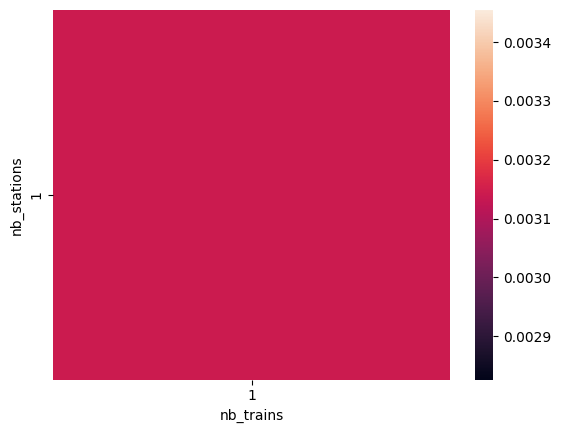

In [63]:
ax = sns.heatmap(df)
plt.show()

### Minizinc

In [13]:
df = performances.pivot(index='nb_stations', columns='nb_trains', values='minizinc')
#print(df)
df = df.sort_index(ascending=False)
print(df)

nb_trains           1         2          3          4          5
nb_stations                                                     
5            0.237803  0.323905  10.148976  10.156622  10.149003
4            0.254320  0.238466   0.249753  10.144396  10.149022
3            0.232199  0.639179   0.419538  10.149806  10.148585
2            0.234372  0.251190   5.370259  10.147903  10.152195
1            0.259734  0.248231   0.258176   0.450792  10.144518


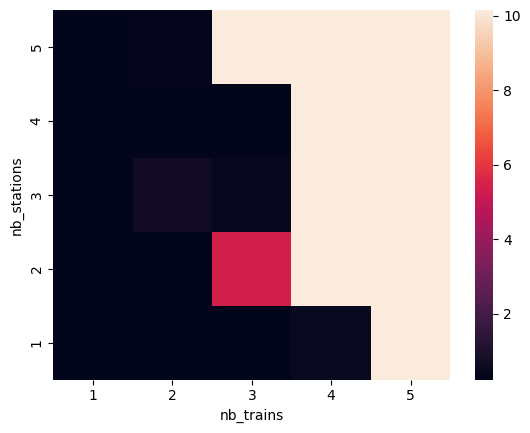

In [14]:
ax = sns.heatmap(df)
plt.show()

### Linear Performance Testing

In [64]:
NOMINAL_NB_TRAINS = 5
NOMINAL_NB_STATIONS = 3
NOMINAL_PROBA_DELAY = 0.1

In [65]:
linear_performances = linear_load_testing(
    [OrtoolsRegulationSolver("ortools",60),
     MinizincRegulationSolver("minizinc", "gecode", 60)],
    generate_garage_use_case,
    ranges= {
        "nb_stations": {
            "range": list(range(1, 5, 2)) + list(range(5, 20, 4)),
            "nominal": NOMINAL_NB_STATIONS
        },
        "nb_trains": {
            "range": list(range(1, 5, 2)) + list(range(5, 20, 4)),
            "nominal": NOMINAL_NB_TRAINS
        },
        "delay_proba": {
            "range": [NOMINAL_PROBA_DELAY],
            "nominal": NOMINAL_PROBA_DELAY
        }
    })

if not os.path.isfile('./performances.csv'):
   linear_performances.to_csv("./performances.csv", header=True, index=False)
else:
   linear_performances.to_csv("./performances.csv", mode='a', header=False, index=False)

### Nb_Stations impact

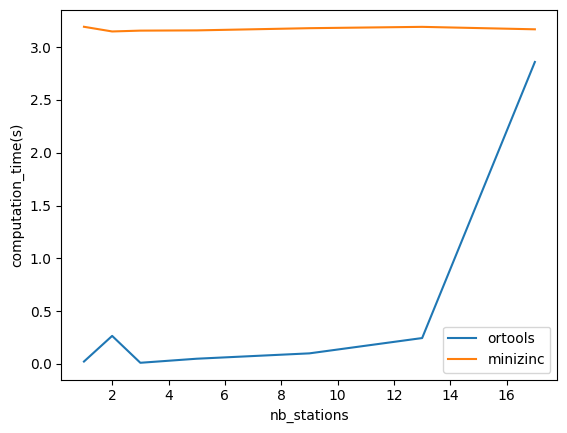

In [66]:
station_df = linear_performances[linear_performances['nb_trains'] == NOMINAL_NB_TRAINS]
station_df = station_df.drop_duplicates(subset=['nb_stations', 'nb_trains'])
station_df = station_df.sort_values(by="nb_stations", ascending=True)
plt.plot(station_df['nb_stations'], station_df['ortools'], label="ortools")
plt.plot(station_df['nb_stations'], station_df['minizinc'], label='minizinc')
plt.xlabel("nb_stations")
plt.ylabel("computation_time(s)")
plt.legend()

### Nb_Trains impact

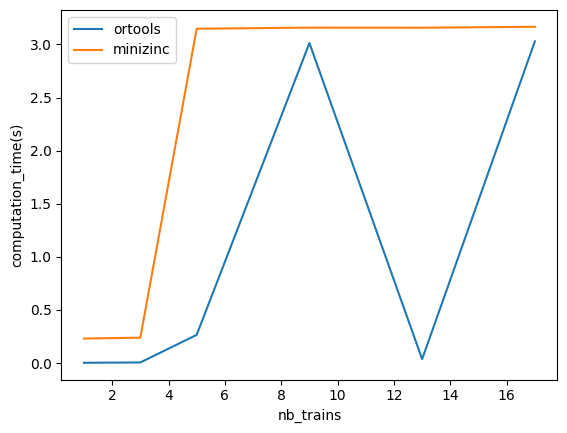

In [67]:
train_df = linear_performances[linear_performances['nb_stations'] == NOMINAL_NB_STATIONS]
train_df = train_df.drop_duplicates(subset=['nb_stations', 'nb_trains'])
train_df = train_df.sort_values(by="nb_trains", ascending=True)
plt.plot(train_df['nb_trains'], train_df['ortools'], label="ortools")
plt.plot(train_df['nb_trains'], train_df['minizinc'], label="minizinc")
plt.xlabel("nb_trains")
plt.ylabel("computation_time(s)")
plt.legend()

## Report from csv

In [4]:
performances_df = pd.read_csv("./performances.csv")

In [5]:
grouped_performances = performances_df.groupby(['nb_stations', 'nb_trains', 'delay_proba']).mean().reset_index()
heatmap_delay_0_1_df = grouped_performances[grouped_performances['delay_proba'] == 0.1].pivot(index='nb_stations', columns='nb_trains', values='ortools')
heatmap_delay_0_1_df.head()

nb_trains,1,4,7,10,13,16
nb_stations,,,,,,
1,0.002527,0.006060,0.007654,0.035278,0.593170,2.090300
4,0.004694,0.045135,0.043108,0.058374,60.051587,60.043953
7,0.005610,0.032780,5.028354,60.065784,60.073595,60.082696
10,0.006320,0.215793,3.235942,60.092125,60.081418,60.159452
13,0.012925,0.097410,17.441864,60.098373,60.100019,60.133188


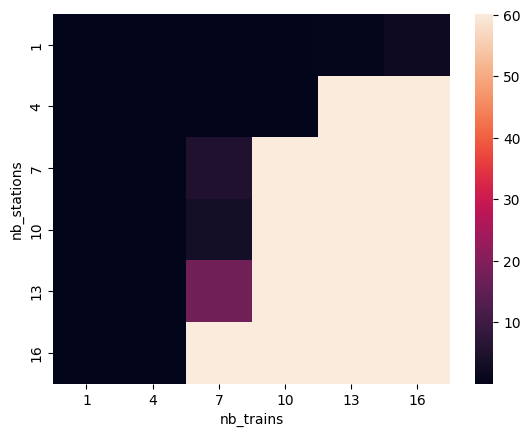

In [6]:
ax = sns.heatmap(heatmap_delay_0_1_df)
plt.show()

In [7]:
heatmap_delay_0_2_df = grouped_performances[grouped_performances['delay_proba'] == 0.2].pivot(index='nb_stations', columns='nb_trains', values='ortools')
heatmap_delay_0_2_df.head()

nb_trains,1,4,7,10,13,16
nb_stations,,,,,,
1,0.002288,0.009469,0.015491,1.265634,1.685972,60.039081
4,0.004954,0.023582,0.422541,60.058743,60.073006,60.050833
7,0.008603,0.076856,12.957137,60.057175,60.114416,60.082194
10,0.005905,0.124694,60.081357,60.074511,60.175135,60.090535
13,0.007817,0.139589,60.068241,60.091068,60.093572,60.190288


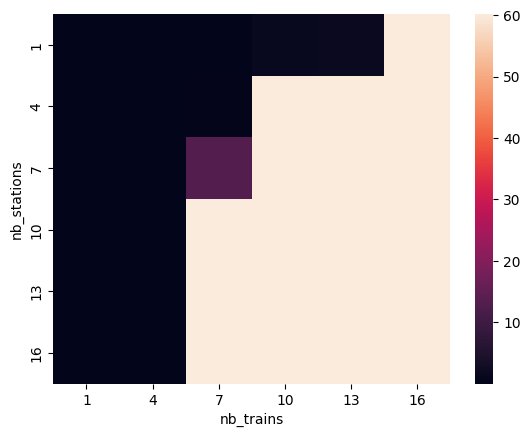

In [8]:
ax = sns.heatmap(heatmap_delay_0_2_df)
plt.show()

In [ ]:
performances_df.to_latex()

## Table

In [5]:
df = load_testing(
    [OrtoolsRegulationSolver("ortools",3600)],
    generate_garage_use_case,
    [
        {'nb_stations':9, 'nb_trains':9, 'delay_proba':0.05}
    ],
    "./table2.csv"
)

In [11]:
df = pd.read_csv("./table2.csv")
df.to_latex(index=False, float_format="%.2f")

'\\begin{tabular}{rrrr}\n\\toprule\nnb_stations & nb_trains & delay_proba & ortools \\\\\n\\midrule\n9.00 & 9.00 & 0.05 & 20.31 \\\\\n\\bottomrule\n\\end{tabular}\n'